# "Concevez une application au service de la santé publique"
_Cleaning Notebook_
13/08 16h

### Importing Modules

In [0]:
## IMPORTATIONS
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', lambda x: '%.0f' % x)
#pd.options.display.float_format = '{:.0f}'.format

import pandas_profiling

import missingno as msno

!pip install python-stdnum
from stdnum.exceptions import *
from stdnum.util import clean, isdigits
from stdnum.ean import *

import string
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
!pip install chartify
import chartify

import scipy.stats as st

import re
import time

from google.colab import files
from google.colab import output

import sys
import os
sys.executable # 'C:\\ProgramData\\Anaconda3\\python.exe'

import IPython.display as ipd

     |████████████████████████████████| 849kB 2.7MB/s 
     |████████████████████████████████| 61kB 2.0MB/s 
     |████████████████████████████████| 942kB 8.0MB/s 


In [0]:
%pprint

Pretty printing has been turned OFF


In [0]:
%load_ext google.colab.data_table

### Defining functions

In [0]:
# uploaded = files.upload()

Saving 1.mp3 to 1.mp3
Saving 2.mp3 to 2.mp3
Saving 3.mp3 to 3.mp3
Saving 4.mp3 to 4.mp3
Saving 5.mp3 to 5.mp3
Saving 6.mp3 to 6.mp3
Saving 7.mp3 to 7.mp3
Saving 8.mp3 to 8.mp3
Saving 9.mp3 to 9.mp3
Saving 10.mp3 to 10.mp3
Saving 11.mp3 to 11.mp3
Saving 12.mp3 to 12.mp3
Saving 13.mp3 to 13.mp3
Saving 14.mp3 to 14.mp3
Saving 15.mp3 to 15.mp3
Saving 16.mp3 to 16.mp3
Saving 17.mp3 to 17.mp3
Saving 18.mp3 to 18.mp3
Saving 19.mp3 to 19.mp3
Saving 20.mp3 to 20.mp3
Saving Djembe_Grave.ogg to Djembe_Grave.ogg
Saving Start.wav.mp3 to Start.wav.mp3
Saving youpi.mp3 to youpi.mp3


In [0]:
# def path_sound(n):
#   cwd = os.getcwd()
#   if n in list(range(1,21)):
#     path = cwd+'/' + str(n) + '.mp3'
#   else:
#     if n == 0:
#       path = cwd+'/' + 'youpi' +'.mp3'
#     else:
#       path = cwd+'/'+'Djembe_Grave.ogg'
#   return path

# def sound(n):
#     return ipd.Audio(path_sound(n), autoplay=True)

In [0]:
def info (df):
    nb_li = df.shape[0]
    nb_co = df.shape[1]
    t = np.empty(nb_li)
    t.fill(nb_li)
    df_l_null = pd.DataFrame(df.T.isna().sum()) # number of null per row
    df_c_null = pd.DataFrame(df.isna().sum()) # number of null per column
    
    # number of rows without any 'null'
    al = len([x for x in df_l_null[0] if x==0])
    nb_ss_null = pd.DataFrame([al]).rename(index={0:'row_wo_null'}).T
    pct_ss_null = pd.DataFrame([al*100/nb_li]).rename(index={0:'row_wo_null'}).T
    # number of rows with all 'null'
    bl = len([x for x in df_l_null[0] if x==nb_co])
    nb_null = pd.DataFrame([bl]).rename(index={0:'row_null'}).T
    pct_null = pd.DataFrame([bl*100/nb_li]).rename(index={0:'row_null'}).T
    # number of mixed rows (with some null)
    cl = len([x for x in df_l_null[0] if (x!=0 and x!=nb_co)])
    nb_mix = pd.DataFrame([cl]).rename(index={0:'row_mix'}).T
    pct_mix = pd.DataFrame([cl*100/nb_li]).rename(index={0:'row_mix'}).T
    info_nb = pd.concat([nb_ss_null, nb_null,
                         nb_mix],axis=1, sort=False).rename(index={0:'nb'})
    info_pct = pd.concat([pct_ss_null, pct_null,
                          pct_mix],axis=1, sort=False).rename(index={0:'pct'})
    info_l = pd.concat([info_nb,info_pct], sort=False)
    # total number of rows
    info_l["row_tot"] = [info_l.T['nb'].sum(), info_l.T['pct'].sum()]
    
    # number of columns without any 'null''
    ac = len([x for x in df_c_null[0] if x==0])
    nb_ss_null = pd.DataFrame([ac]).rename(index={0:'col_wo_null'}).T
    pct_ss_null = pd.DataFrame([ac*100/nb_co]).rename(index={0:'col_wo_null'}).T
    # number of columns with all 'null'
    bc = len([x for x in df_c_null[0] if x==nb_li])
    nb_null = pd.DataFrame([bc]).rename(index={0:'col_null'}).T
    pct_null = pd.DataFrame([bc*100/nb_co]).rename(index={0:'col_null'}).T
    # number of mixed columns (with some null)
    cc = len([x for x in df_c_null[0] if (x!=0 and x!=nb_li)])
    nb_mix = pd.DataFrame([cc]).rename(index={0:'col_mix'}).T
    pct_mix = pd.DataFrame([cc*100/nb_co]).rename(index={0:'col_mix'}).T
    info_nb = pd.concat([nb_ss_null, nb_null,
                         nb_mix],axis=1, sort=False).rename(index={0:'nb'})
    info_pct = pd.concat([pct_ss_null, pct_null, pct_mix],
                         axis=1, sort=False).rename(index={0:'pct'})
    info_c = pd.concat([info_nb,info_pct], sort=False)
    # total number of columns
    info_c["col_tot"] = [info_c.T['nb'].sum(), info_c.T['pct'].sum()]
    
    info = pd.concat([info_l,info_c], axis=1, sort=False)
    
    return info

In [0]:
sound(1)

### Importing dataset

In [0]:
# On Google Colab: Upload a file from Google Drive via PyDrive
# Install PyDrive wrapper & import libraries (once)
!pip install -U -q PyDrive 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
# Authenticate and create PyDrive client (once)
auth.authenticate_user() 
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# Download a file based on its file ID (shareable link)
file_id = '1Ua1RzJPjLAaDg9kgz3SmusmGoUO53OOx'
downloaded = drive.CreateFile({'id': file_id})
sound(2) # notifying successful authentication

In [0]:
downloaded.GetContentFile('en.openfoodfacts.org.products.csv')  
df = pd.read_csv('en.openfoodfacts.org.products.csv',
                 sep='\t', low_memory=False, encoding ='utf-8')

In [0]:
# df.head(1)

In [0]:
sound(2)

## Data preprocessing

### Description

In [0]:
# Shape of the dataset
dfshape = df.shape # (954463, 175)

In [0]:
 # my_info = info(df)
 # my_info

14 columns with no entry, no row has all the columns filled.

In [0]:
# General description 
desc_df = df.describe(include='all')
# Types and content of the columns
desc_type = pd.DataFrame(df.dtypes, columns=['type']).T
# Null stats per column
nb_null = (dfshape[0]-desc_df.loc["count"].T)
pct_null = (dfshape[0]-desc_df.loc["count"].T)*100/dfshape[0]
desc_null = pd.DataFrame([nb_null, pct_null], index=['nb null','pct null'])
# Concatenate general, type and null stats
my_desc = pd.concat([desc_type, desc_null, desc_df])

In [0]:
my_desc

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,packaging,packaging_tags,brands,brands_tags,categories,categories_tags,categories_en,origins,origins_tags,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_en,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_en,ingredients_text,allergens,allergens_en,traces,traces_tags,traces_en,serving_size,serving_quantity,no_nutriments,additives_n,additives,additives_tags,additives_en,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil,ingredients_that_may_be_from_palm_oil_tags,nutrition_grade_fr,nova_group,pnns_groups_1,pnns_groups_2,states,states_tags,states_en,main_category,main_category_en,image_url,image_small_url,image_ingredients_url,image_ingredients_small_url,image_nutrition_url,image_nutrition_small_url,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,-butyric-acid_100g,-caproic-acid_100g,-caprylic-acid_100g,-capric-acid_100g,-lauric-acid_100g,-myristic-acid_100g,-palmitic-acid_100g,-stearic-acid_100g,-arachidic-acid_100g,-behenic-acid_100g,-lignoceric-acid_100g,-cerotic-acid_100g,-montanic-acid_100g,-melissic-acid_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,-alpha-linolenic-acid_100g,-eicosapentaenoic-acid_100g,-docosahexaenoic-acid_100g,omega-6-fat_100g,-linoleic-acid_100g,-arachidonic-acid_100g,-gamma-linolenic-acid_100g,-dihomo-gamma-linolenic-acid_100g,omega-9-fat_100g,-oleic-acid_100g,-elaidic-acid_100g,-gondoic-acid_100g,-mead-acid_100g,-erucic-acid_100g,-nervonic-acid_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,-sucrose_100g,-glucose_100g,-fructose_100g,-lactose_100g,-maltose_100g,-maltodextrins_100g,starch_100g,polyols_100g,fiber_100g,proteins_100g,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-dried_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
type,object,object,object,int64,object,int64,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,float64,object,object,object,object,object,object,object,object,float64,object,object,object,object,float64,float64,float64,object,object,object,float64,float64,object,float64,float64,object,object,float64,object,object,object,object,object,object,object,object,object,object,object,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float

In [0]:
sound(3)

### Memory usage reduction

In order to facilitate the manipulation, we can specify the format of each column while loading the data in a pandas dataframe.
The precision of float16 is only 3 digit vs. 15 for float64. 

In [0]:
# # Checking the memory usage
# df.info(memory_usage='deep')

In [0]:
## Changing format of object and float64 columns
my_dtypes = {}
# object -> category (if nb unique < 10000)
for col in df.columns.values:
    if df[col].dtype == 'object' and  len(df[col].unique()) < 10000 :
        my_dtypes[col] = 'category'
# float64 -> float16
for col in df.columns.values:
    if df[col].dtype == 'float64':
        my_dtypes[col] = 'float16'

In [0]:
# Reload data 
df = pd.read_csv('en.openfoodfacts.org.products.csv', dtype=my_dtypes, 
                 sep='\t', low_memory=False, encoding ='utf-8')  # nrows=1000,
# Recheck memory usage
df.info(memory_usage='deep') # 'deep': enables more accurate memory usage report

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 954463 entries, 0 to 954462
Columns: 175 entries, code to carnitine_100g
dtypes: category(23), float16(117), int64(2), object(33)
memory usage: 2.2 GB


In [0]:
sound(4)

Main conclusions : 
- Description :
  954463 rows and 175 columns
  some of them categorical, 
  some of them numerical
- Memory usage reduction : 
  4.6 GB -> 2.2 GB

### Pandas Data Profiling report

In [0]:
dfcopy = df.copy(deep = True)

In [0]:
# Generating a Data Profiling html report via pandas_profiling
# profile = pandas_profiling.ProfileReport(dfcopy) #, check_correlation = False
# profile.to_file("OFFacts_report2_3.html")
# profile

In [0]:
# # extract rejected columns (based on correlation coeff greater than 0.9)
# rejected_variables_90 = profile.get_rejected_variables(threshold=0.9)
# len(rejected_variables_90)

In [0]:
sound(5)

Main conclusions : 

### Filtering out unimportant columns
#### 1. Non relevant columns
Some columns can immediately be classied as non useful for our project and can be dropped : 
- 5 columns concerning to the image of the product: 'image_small_url',	'image_ingredients_url',	'image_ingredients_small_url',	'image_nutrition_url'	'image_nutrition_small_url'
- 3 columns concerning the level of completion of the row: 'states', 'states_tags', 'states_en' 


In [0]:
li_col_del = ['image_url', 'image_small_url',	'image_ingredients_url',
              'image_ingredients_small_url',	'image_nutrition_url',
              'image_nutrition_small_url',
              'states', 'states_tags', 'states_en' ]
# Filtering out 8 non relevant columns
dfcopy.drop(columns=li_col_del, inplace=True)
dfcopy.shape

(954463, 166)

#### 2. Almost empty columns

In [0]:
# Checking all 'null' columns
nbnotnulldf = pd.DataFrame((~dfcopy.isna()).sum(axis =0),
                           columns=['nb'])
nbnotnulldf.sort_values(by=['nb'], axis=0, ascending=True, inplace=True)
nbnotnulldf.T.head(150)

,ingredients_that_may_be_from_palm_oil,cities,allergens_en,-elaidic-acid_100g,-gondoic-acid_100g,-mead-acid_100g,-erucic-acid_100g,-nervonic-acid_100g,-lignoceric-acid_100g,no_nutriments,-melissic-acid_100g,ingredients_from_palm_oil,water-hardness_100g,-caproic-acid_100g,-dihomo-gamma-linolenic-acid_100g,-butyric-acid_100g,-stearic-acid_100g,-montanic-acid_100g,-myristic-acid_100g,-behenic-acid_100g,-caprylic-acid_100g,chlorophyl_100g,glycemic-index_100g,-gamma-linolenic-acid_100g,-palmitic-acid_100g,-cerotic-acid_100g,phylloquinone_100g,-arachidic-acid_100g,-capric-acid_100g,-lauric-acid_100g,-maltose_100g,nucleotides_100g,-maltodextrins_100g,carnitine_100g,-arachidonic-acid_100g,-oleic-acid_100g,beta-glucan_100g,additives,choline_100g,serum-proteins_100g,inositol_100g,omega-9-fat_100g,casein_100g,-glucose_100g,chromium_100g,molybdenum_100g,-fructose_100g,beta-carotene_100g,taurine_100g,-eicosapentaenoic-acid_100g,silica_100g,-sucrose_100g,-docosahexaenoic-acid_100g,ph_100g,-linoleic-acid_100g,caffeine_100g,fluoride_100g,bicarbonate_100g,fruits-vegetables-nuts-dried_100g,collagen-meat-protein-ratio_100g,-alpha-linolenic-acid_100g,omega-6-fat_100g,starch_100g,-lactose_100g,carbon-footprint_100g,chloride_100g,biotin_100g,iodine_100g,polyols_100g,energy-from-fat_100g,vitamin-k_100g,selenium_100g,omega-3-fat_100g,manganese_100g,copper_100g,vitamin-e_100g,pantothenic-acid_100g,folates_100g,cocoa_100g,zinc_100g,fruits-vegetables-nuts_100g,vitamin-b9_100g,vitamin-b12_100g,phosphorus_100g,magnesium_100g,vitamin-b6_100g,vitamin-d_100g,carbon-footprint-from-meat-or-fish_100g,fruits-vegetables-nuts-estimate_100g,alcohol_100g,vitamin-b2_100g,ingredients_from_palm_oil_tags,vitamin-b1_100g,vitamin-pp_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,ingredients_that_may_be_from_palm_oil_tags,potassium_100g,first_packaging_code_geo,cities_tags,origins_tags,origins,traces,emb_codes_tags,emb_codes,traces_tags,traces_en,allergens,manufacturing_places_tags,manufacturing_places,generic_name,purchase_places,vitamin-a_100g,vitamin-c_100g,iron_100g,trans-fat_100g,cholesterol_100g,calcium_100g,labels,labels_tags,labels_en,stores,packaging_tags,packaging,additives_en,additives_tags,nutrition-score-uk_100g,nutrition-score-fr_100g,nutrition_grade_fr,serving_size,serving_quantity,quantity,fiber_100g,nova_group,main_category_en,main_category,categories_en,categories_tags,categories,ingredients_that_may_be_from_palm_oil_n,ingredients_from_palm_oil_n,additives_n,ingredients_text,brands_tags,brands,saturated-fat_100g,sodium_100g,salt_100g,sugars_100g,fat_100g,carbohydrates_100g,proteins_100g,energy_100g,product_name,pnns_groups_1,countries_en,countries,countries_tags,pnns_groups_2,creator,created_datetime,last_modified_t,created_t,url,last_modified_datetime,code
nb,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,2,3,3,3,3,3,3,4,7,9,12,14,15,15,20,20,29,30,34,36,37,38,48,55,58,66,69,84,96,101,117,128,138,197,221,222,254,273,286,287,349,377,392,402,492,528,572,757,948,1016,1315,1486,1850,2286,2341,2969,3079,4389,4497,5724,5971,6196,6666,7667,7776,8240,9069,9439,11549,11737,11941,12255,12571,24227,24281,25787,26011,39971,42868,52543,52629,60264,61952,61978,78169,78169,80681,82155,82186,90676,118066,138881,142425,142479,144226,144975,145497,159491,159515,159515,172337,178136,178139,237485,237485,265819,265819,265819,271817,271932,292258,296733,311177,345085,345085,345154,345154,345156,439597,439597,439597,439597,570120,570167,709820,721199,721218,725435,739163,739214,741437,744167,876610,944390,952425,952425,952425,954115,954460,954462,954463,954463,954463,954463,954463


In [0]:
# Displaying a table with bins
mask = pd.cut(nbnotnulldf['nb'], [-1,0,5,10,100,300,1000000]) # 
mask.value_counts(normalize=False, sort=False)

(-1, 0]            14
(0, 5]             15
(5, 10]             2
(10, 100]          19
(100, 300]         11
(300, 1000000]    105
Name: nb, dtype: int64

<BarContainer object of 40 artists>

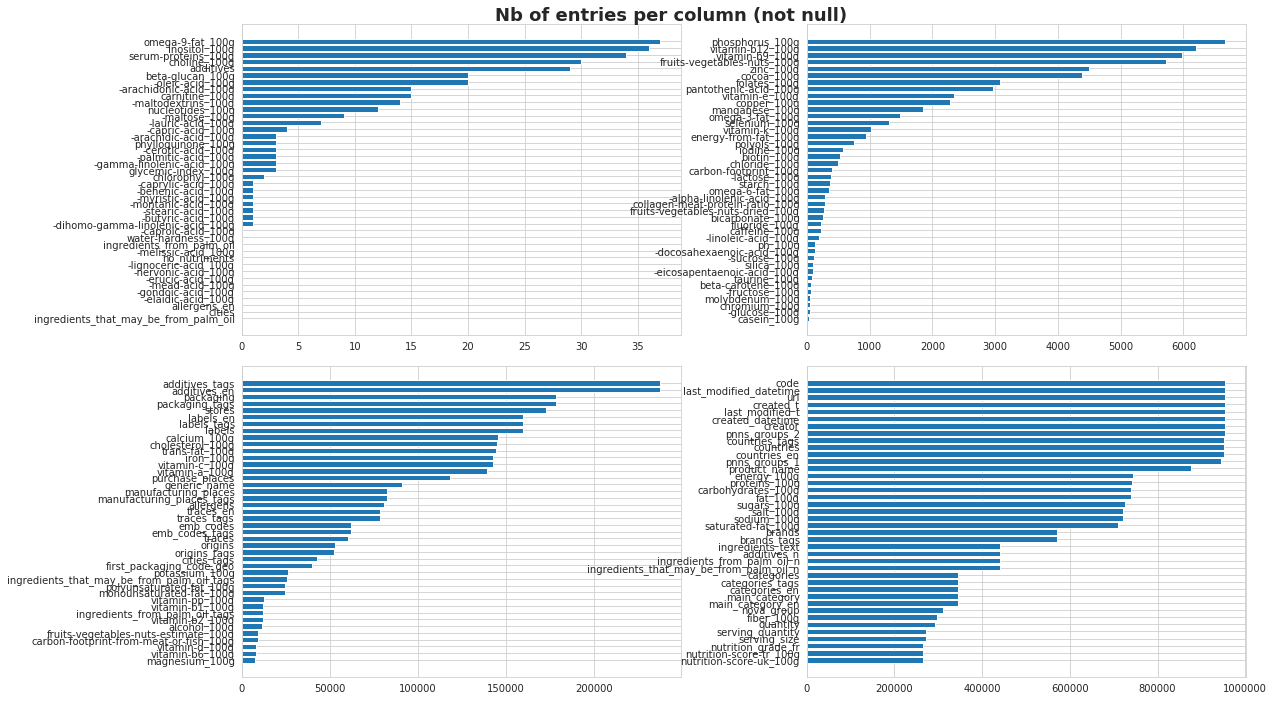

In [0]:
# Plotting barplots of nb of not null per column
fig = plt.figure(figsize = (18, 12))
grid = plt.GridSpec(2, 4, wspace=0.8, hspace=0.1)
np.warnings.filterwarnings('ignore')

fig.suptitle("Nb of entries per column (not null)",
             x=0.32, y=0.9, ha='left', va='top', fontsize=18, fontweight = 'bold')

ax1 = plt.subplot(grid[0, 0:2])
ax1.barh(nbnotnulldf['nb'].index.to_list()[:42] , width=nbnotnulldf['nb'].values[:42])
ax2 = plt.subplot(grid[0, 2:4])
ax2.barh(nbnotnulldf['nb'].index.to_list()[42:84] , width=nbnotnulldf['nb'].values[42:84])
ax3 = plt.subplot(grid[1, 0:2])
ax3.barh(nbnotnulldf['nb'].index.to_list()[84:126] , width=nbnotnulldf['nb'].values[84:126])
ax4 = plt.subplot(grid[1, 2:4])
ax4.barh(nbnotnulldf['nb'].index.to_list()[126:170] , width=nbnotnulldf['nb'].values[126:170])


In [0]:
# Displaying names of columns with less than 300 entries (0.031%)
mask=pd.cut(nbnotnulldf['nb'], [-1,300])
li_col_del = mask[~mask.values.isna()].index
len(li_col_del), li_col_del

(61, Index(['ingredients_that_may_be_from_palm_oil', 'cities', 'allergens_en', '-elaidic-acid_100g', '-gondoic-acid_100g', '-mead-acid_100g', '-erucic-acid_100g', '-nervonic-acid_100g', '-lignoceric-acid_100g', 'no_nutriments', '-melissic-acid_100g', 'ingredients_from_palm_oil', 'water-hardness_100g', '-caproic-acid_100g', '-dihomo-gamma-linolenic-acid_100g', '-butyric-acid_100g', '-stearic-acid_100g', '-montanic-acid_100g', '-myristic-acid_100g', '-behenic-acid_100g', '-caprylic-acid_100g', 'chlorophyl_100g', 'glycemic-index_100g', '-gamma-linolenic-acid_100g', '-palmitic-acid_100g', '-cerotic-acid_100g', 'phylloquinone_100g', '-arachidic-acid_100g', '-capric-acid_100g', '-lauric-acid_100g', '-maltose_100g', 'nucleotides_100g', '-maltodextrins_100g', 'carnitine_100g', '-arachidonic-acid_100g', '-oleic-acid_100g', 'beta-glucan_100g', 'additives', 'choline_100g', 'serum-proteins_100g', 'inositol_100g', 'omega-9-fat_100g', 'casein_100g', '-glucose_100g', 'chromium_100g', 'molybdenum_100g

61 columns contain less than 300 entries.
Some of them (11) might nevertheless be used to complete other columns with similar content and require more investigation, or could be used on small specialized subsets of data (mineral waters, energizing drinks, meats...). They should not be dropped at first :
- 'additives',
- 'chromium_100g',
- 'molybdenum_100g',
- 'taurine_100g'
- 'silica_100g',
- 'ph_100g',
- 'caffeine_100g',
- 'fluoride_100g',
- 'bicarbonate_100g',
- 'fruits-vegetables-nuts-dried_100g',
- 'collagen-meat-protein-ratio_100g'

In [0]:
# Removing 11 columns from the "to-be-deleted" columns list 
li_col_not_del =  ['additives', 'chromium_100g', 'molybdenum_100g', 
                   'taurine_100g', 'silica_100g', 'ph_100g', 'caffeine_100g', 
                   'fluoride_100g', 'bicarbonate_100g',
                   'fruits-vegetables-nuts-dried_100g', 
                   'collagen-meat-protein-ratio_100g']
li_col_del = [i for i in li_col_del if i not in li_col_not_del]
# Filtering out 50 columns with less than 300 entries (0.021%)
dfcopy.drop(columns=li_col_del, inplace=True)
dfcopy.shape

(954463, 116)

In [0]:
sound(6)

#### 3. Columns with redundant information

Some of the columns seem to contain similar information. For example : 
  - 'created_t' vs.	'created_datetime'
  - 'last_modified_t' vs.	'last_modified_datetime'
  - 'brands' vs.	'brands_tags'
  - 'categories	' vs.	'categories_tags'  vs.	'categories_en'  
  - 'origins' vs.	'origins_tags'
  - 'manufacturing_places' vs.	'manufacturing_places_tags'
  - 'labels' vs.	'labels_tags'  vs.	'labels_en' 
  - 'emb_codes' vs.	'emb_codes_tags'
  - 'countries' vs.	'countries_tags'  vs.	'countries_en'
  - 'traces' vs.	'traces_tags'  vs.	'traces_en'
  - 'additives_n' vs. 'additives' vs.	'additives_tags'  vs.	'additives_en'


Let's see if some of them can be dropped or their content gathered in only one column.
To that end, we define a function '**comp_df**' that :
- compares the content of two columns col1 and col2 of the dataframe
- prints the number or rows with 1) both columns, 2) col1 only, 3) col2 only, and 4) none of them filled
- returns indexes of 1) data in both columns, 2) data only in col1, 3) data only in col2, and 4) no data at all.

After that, we check and compare the content of the columns when both are filled in order to get familiar with the content of the database.

In [0]:
def comp_df (df, col1, col2):
  mboth = (~df[[col1,col2]].isna()).sum(axis=1)==2 # mask for both cells filled
  mone = (~df[[col1,col2]].isna()).sum(axis=1)==1 # mask for only one cell filled
  mcol1 = mone & ~df[col1].isna() # mask for only col1 cell filled
  mcol2 = mone & ~df[col2].isna() # mask for only col2 cell filled
  mnone = ~mone & ~mboth
  ind_both = df.index[mboth].to_list()
  ind_col1 = df.index[mcol1].to_list()
  ind_col2 = df.index[mcol2].to_list()
  ind_none = df.index[mnone].to_list()
  #ind_none = df.index[mnone].tolist()
  print("nb rows both filled: ", len(ind_both))
  print("nb rows with only", col1, "filled: ", len(ind_col1))
  print("nb rows with only", col2, "filled: ", len(ind_col2))
  print("nb rows not filled: ", len(ind_none))
  return(ind_both, ind_col1, ind_col2, ind_none)

Here is an example of the code we have used to address 'brands' and 'brands_tags' columns:

In [0]:
# Compares content of 2 columns, print info and returns indexes 
# c1 = 'brands'
# c2 = c1+'_tags'
# t_ind = comp_df(dfcopy, c1, c2)
# dfcopy.loc[(t_ind[1]+t_ind[2])[53:57],[c1, c2]]

In [0]:
# # Displaying cells when both columns are filled
# dfcopy.loc[t_ind[0], [c1,c2]].head(4)

In [0]:
# # Loop comparing the content of 'XXX_en' and 'XXX_tags' columns
# li_col = ['categories', 'labels', 'countries', 'traces', 'additives']
# for c in li_col:
#   c1 = c+'_en'
#   c2 = c+'_tags'
#   t_ind = comp_df(dfcopy, c1, c2)

In [0]:
# # Displaying 'XXX_en' and 'XXX_tags' cells
# dfcopy.loc[t_ind[0], [c1,c2]].head(4)

After examination of all the columns above-listed, we decide :
- to set the entries of the 'XXX' column to NaN if not matching with a non NaN value in the 'XXX_tags' column (as we found that they correspond to erroneous entries ('?', '/', '-', etc.));
- to drop 'created_t' and 'last_modified_t';
- to drop 'packaging_tags', 'brands_tags', 'categories_tags', 'origins_tags', 'manufacturing_places_tags', 'labels_tags', 'emb_codes_tags', 'countries_tags', 'traces_tags', 'additives_tags', as the data they contain are redundant with 'XXX' or 'XXX_en' columns; 
- to drop 'additives' column, as it does not contain enough data (29 entries), that are however in english in 'additives_en'
- to keep 'XXX_en' columns, as they contain useful and sometimes original data;
- to keep 'XXX' columns.

In [0]:
# Setting values of the 'XXX' column to NaN if not corresponding to other
# than NaN value in 'XXX_tags'
li_col=['packaging', 'brands', 'categories', 'origins', 'manufacturing_places',
        'labels', 'emb_codes','countries', 'traces','additives']
for c in li_col:
  c1 = c
  c2 = c+'_tags'
  print('COLUMN', c, 'before:')
  t_ind = comp_df(dfcopy, c1, c2)
  dfcopy.loc[t_ind[1], [c1,c2]] = np.nan
  print('COLUMN', c, 'after:')
  t_ind = comp_df(dfcopy, c1, c2)


COLUMN packaging before:
nb rows both filled:  178134
nb rows with only packaging filled:  5
nb rows with only packaging_tags filled:  2
nb rows not filled:  776322
COLUMN packaging after:
nb rows both filled:  178134
nb rows with only packaging filled:  0
nb rows with only packaging_tags filled:  2
nb rows not filled:  776327
COLUMN brands before:
nb rows both filled:  570112
nb rows with only brands filled:  55
nb rows with only brands_tags filled:  8
nb rows not filled:  384288
COLUMN brands after:
nb rows both filled:  570112
nb rows with only brands filled:  0
nb rows with only brands_tags filled:  8
nb rows not filled:  384343
COLUMN categories before:
nb rows both filled:  345154
nb rows with only categories filled:  2
nb rows with only categories_tags filled:  0
nb rows not filled:  609307
COLUMN categories after:
nb rows both filled:  345154
nb rows with only categories filled:  0
nb rows with only categories_tags filled:  0
nb rows not filled:  609309
COLUMN origins before:
n

In [0]:
# Dropping unuseful columns
li_col_del=['created_t', 'last_modified_t','packaging_tags',
                   'brands_tags', 'categories_tags', 'origins_tags', 
                   'manufacturing_places_tags', 'labels_tags',
                   'emb_codes_tags','countries_tags', 'traces_tags',
                   'additives_tags', 'additives']
dfcopy.drop(columns = li_col_del, inplace=True)

In [0]:
# Changing the name of some of the columns
dfcopy.rename(columns={'nutrition-score-fr_100g':'nutrition-score-fr',
                       'nutrition-score-uk_100g':'nutrition-score-uk'},
              inplace=True)


Some columns are related and provide information useful to retrieve data via feature engineering.
To help the automatization of these tasks, we categorize the columns as follows :

**cat_fat**: 'saturated_fat_100g', 'monounsaturated_fat_100g', 'polyunsaturated_fat_100g', 'trans-fat_100g', 'cholesterol_100g'

**cat_poly_fat**: 'omega-3-fat_100g', 'omega-6-fat_100g'

**cat_carb**: 'sugars_100g', 'starch_100g', 'polyols_100g', 'fibers_100g', '-lactose_100g'

**cat_comp**: cat_fat, cat_carb, 'proteins_100g'

**cat_vit-oligo**:  'vitamin-a_100g',	'vitamin-d_100g',	'vitamin-e_100g',	'vitamin-k_100g',	'vitamin-c_100g',	'vitamin-b1_100g',	'vitamin-b2_100g',	'vitamin-pp_100g',	'vitamin-b6_100g',	'vitamin-b9_100g',	'folates_100g',	'vitamin-b12_100g',	'biotin_100g',	'pantothenic-acid_100g','silica_100g', 'bicarbonate_100g',	'potassium_100g',	'chloride_100g',	'calcium_100g',	'phosphorus_100g',	'iron_100g',	'magnesium_100g',	'zinc_100g',	'copper_100g',	'manganese_100g',	'fluoride_100g', 'selenium_100g, 'chromium_100g', 'molybdenum_100g', 'iodine_100g',	'caffeine_100g', 'taurine_100g', 'cocoa_100g'

In [0]:
# Making list of columns with similar or complementary content

li_cat_carb = ['sugars_100g', 'starch_100g', 'polyols_100g',
            'fibers_100g', '-lactose_100g']
li_cat_fat = ['saturated_fat_100g', 'monounsaturated_fat_100g',
              'polyunsaturated_fat_100g', 'trans-fat_100g', 'cholesterol_100g']
li_cat_poly_fat = ['omega-3-fat_100g', 'omega-6-fat_100g']

li_cat_comp = ['fat_100g','carbohydrates_100g', 'proteins_100g']

li_cat_vit_oligo = ['vitamin-e_100g', 'vitamin-k_100g',
                    'vitamin-c_100g', 'vitamin-b1_100g', 'vitamin-b2_100g',
                    'vitamin-pp_100g','vitamin-b6_100g', 'vitamin-b9_100g',
                    'folates_100g', 'vitamin-b12_100g', 'biotin_100g',
                    'pantothenic-acid_100g', 'silica_100g', 'bicarbonate_100g',
                    'potassium_100g', 'chloride_100g', 'calcium_100g',
                    'phosphorus_100g', 'iron_100g', 'magnesium_100g',
                    'zinc_100g', 'copper_100g', 'manganese_100g',
                    'fluoride_100g', 'selenium_100g', 'chromium_100g',
                    'molybdenum_100g', 'iodine_100g', 'caffeine_100g',
                    'taurine_100g', 'cocoa_100g']

li_cat_nutri = ['nutrition_grade_fr', 'nova_group', 
                 'nutrition-score-fr', 'nutrition-score-uk',]
# li_cat_keys = ['code', 'code_val', 'url', 'creator',
#                'created_datetime', 'last_modified_datetime']
# li_cat_id = ['product_name', 'generic_name', 'quantity', 'packaging',
#              'brands','serving_size', 'serving_quantity']
# li_cat_cat = ['categories', 'categories_en', 'labels', 'labels_en',
#               'pnns_groups_1', 'pnns_groups_2', 'main_category',
#               'main_category_en']
# li_cat_geo = ['origins', 'manufacturing_places', 'emb_codes',
#               'first_packaging_code_geo', 'cities_tags', 'purchase_places',
#               'stores', 'countries', 'countries_en']
# li_ca_content = ['ingredients_text', 'allergens', 'traces', 'traces_en',
#                  'additives_n', 'additives_en', 'ingredients_from_palm_oil_n',
#                  'ingredients_from_palm_oil_tags',
#                  'ingredients_that_may_be_from_palm_oil_n',
#                  'ingredients_that_may_be_from_palm_oil_tags']
# li_cat_scores = ['carbon-footprint_100g',
#                  'carbon-footprint-from-meat-or-fish_100g',
#                  'fruits-vegetables-nuts_100g', 'fruits-vegetables-nuts-dried_100g',
#                  'fruits-vegetables-nuts-estimate_100g', 'collagen-meat-protein-ratio_100g']

In [0]:
#  msno.matrix(dfcopy.loc[:,'code':'ingredients_text'])

In [0]:
#  msno.bar(dfcopy.loc[:,'code':'ingredients_text'])

In [0]:
#  # Detecting correlation in the completion of data between different columns
# msno.heatmap(dfcopy.loc[:,'code':'ingredients_text'])

In [0]:
#  # Detecting correlation in the completion of data between different columns
# msno.heatmap(dfcopy.loc[:,['energy_100g','energy-from-fat_100g']+li_cat_comp+li_cat_carb+li_cat_fat+li_cat_poly_fat+li_cat_nutri])

 **__*****____*****_____*****____*****_____*****____*****_____*****____*****_____*****____*****_____*****____*****_____*****____*****_____*****____*****_____*****____*****_____*****____*****_____*****____*****_____*****____*****_____*****____*****_____*****____*****_____*****____*****_____*****____*****_____*****____*****_____*****____*****_____*****____*****

In [0]:
sound(7)

  ### 4. Dropping inoperable rows

We need to get rid of inoperable rows. We will define operability of a row as follows:

condition 1 - the product can be identified, at least by a unique combination of name, brand and quantity ('product_name', 'quantity', 'brands'), or by a valid and unique barcode ('code')
AND
condition 2 - at least one numerical information is provided i.e. one of the features 'XXX_100g' or one type of nutritional score

* Condition 1:

Let's first check the 'code' column for completion, duplicates and validity of the data:


In [0]:
# Checking for completion of the 'code' column
dfcopy['code'].isna().sum()

0

In [0]:
# Checking for duplicates on 'code' column
dfdup = dfcopy[dfcopy.duplicated(subset=['code'], keep=False)].sort_values(by=['code'])

In [0]:
dfdup.head(4)

,code,url,creator,created_datetime,last_modified_datetime,product_name,generic_name,quantity,packaging,brands,categories,categories_en,origins,manufacturing_places,labels,labels_en,emb_codes,first_packaging_code_geo,cities_tags,purchase_places,stores,countries,countries_en,ingredients_text,allergens,traces,traces_en,serving_size,serving_quantity,additives_n,additives_en,ingredients_from_palm_oil_n,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_tags,nutrition_grade_fr,nova_group,pnns_groups_1,pnns_groups_2,main_category,main_category_en,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,omega-6-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,-lactose_100g,starch_100g,polyols_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-dried_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,carbon-footprint_100g,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr,nutrition-score-uk
15629,0016000459335,http://world-en.openfoodfacts.org/product/0016...,openfoodfacts-contributors,2017-01-06T03:05:25Z,2018-11-08T18:44:39Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,États-Unis,United States,NaN,NaN,NaN,NaN,NaN,0,nan,NaN,nan,NaN,nan,NaN,NaN,nan,unknown,unknown,NaN,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
15630,0016000459335,http://world-en.openfoodfacts.org/product/0016...,openfoodfacts-contributors,2017-01-06T03:05:25Z,2018-11-08T18:44:39Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,United States,United States,NaN,NaN,NaN,NaN,NaN,nan,nan,NaN,nan,NaN,nan,NaN,NaN,nan,unknown,unknown,NaN,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
18309,0019320001376,http://world-en.openfoodfacts.org/product/0019...,openfoodfacts-contributors,2013-07-18T01:24:35Z,2018-11-24T22:40:00Z,0.75 oz Nabisco Airplane Cookies - Honey,NaN,NaN,NaN,"Kraft Foods Inc.,Nabisco,Monsanto Company",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,États-Unis,United States,NaN,NaN,NaN,NaN,NaN,0,nan,NaN,nan,NaN,nan,NaN,NaN,nan,unknown,unknown,NaN,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
18310,0019320001376,http://world-en.openfoodfacts.org/product/0019...,openfoodfacts-contributors,2013-07-18T01:24:35Z,2019-05-11T08:04:19Z,0.75 oz Nabisco Airplane Cookies - Honey,NaN,NaN,NaN,"Kraft Foods Inc.,Nabisco,Monsanto Company",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,United States,United States,NaN,NaN,NaN,NaN,NaN,nan,nan,NaN,nan,NaN,nan,NaN,NaN,nan,unknown,unknown,NaN,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,n

We found that the duplicated rows have sometimes a different rate of completion of the columns.

We keep the row with less NaN in each group of duplicates.

In [0]:
# groupping duplicates by code
gk = dfdup.groupby('code')
li_dup_code = dfdup['code'].unique()
get_sum_notna = lambda x : gk.get_group(x).isna().sum(axis=1)
get_argmax = lambda x : get_sum_notna(x).argmax()
# list of unique indexes to drop among all the duplicates (the one with more NaN)
ind_keep = [get_argmax(code) for code in li_dup_code]
ind_drop = [x for x in list(dfdup.index) if x not in ind_keep]
# dropping the rows
dfcopy.drop(index=ind_drop,inplace=True)

We will create a new column 'code_val' indicating if the barcode is valid.

In [0]:
# Verification of barcodes (EAN-13, EAN-8 and UPC (12-digit) format)
# Creation of a new column : barcode valid or not
dfcopy.insert(1,'code_val', list(map(is_valid, dfcopy['code'].values))) # A TESET
print("nb of valid codes: ", dfcopy['code_val'].sum())
print("nb of invalid codes: ", (~dfcopy['code_val']).sum())
print("pctage of valid codes: ", dfcopy['code_val'].sum()*100/dfcopy.shape[0], "%")

nb of valid codes:  919751
nb of invalid codes:  34551
pctage of valid codes:  96.37944801540812 %


When the code is not valid, we will check if the product can be identified by a unique combination of "product_name", "quantity", "brands"  that allow to detect possible duplicates. (At least one of the three must be filled i.e. not NaN).

In [0]:
key_cols = ['product_name', 'quantity', 'brands']

In [0]:
# Checking for invalid 'product_name' (less than 2 characters)
df_prod_notna = pd.DataFrame(dfcopy['product_name'].dropna())
li_ind_all = df_prod_notna.index.to_list()
li_len_prod = list(map(len, df_prod_notna))
li_ind_len = list(zip(li_ind_all,li_len_prod))
ind_wrong_names = [ind for ind, length in li_ind_len if length < 2]
len(ind_wrong_names), dfcopy.loc[ind_wrong_names]['product_name'].to_list()

(0, [])

In [0]:
# Replacing invalid names with np.NaN
dfcopy.loc[ind_wrong_names,['product_name']] = np.nan

In [0]:
# Checking for 'brands' (less than 2 characters)
df_brands_notna = dfcopy['brands'].dropna()
li_ind_all = df_brands_notna.index.to_list()
li_len_brands = list(map(len, df_brands_notna))
li_ind_len = list(zip(li_ind_all,li_len_brands))
ind_wrong_names = [ind for ind, length in li_ind_len if length < 2]
len(ind_wrong_names), dfcopy.loc[ind_wrong_names]['brands'].unique()

(5429, array(['K', 'a', 'G', 'M', 'u', 'U', 'T', 'c', 'V', 'R', 'Q', 'X', 'I',
       'J', '6', 'Z', 'E', '1', 'Y', 'D', 'Я', 'Д', 'A', 'S', 'É', '5',
       '٣', '8', 'g', 'p', 'r', 'm'], dtype=object))

In [0]:
df_quantity.drop(columns = df_quantity.columns, inplace=True)

In [0]:
### Function decomposing 'quantity' in groups of (numerical value, unit)

# To ensure safe execution of function 'float'
def safe_exe(def_val, function, *args):
    try: return function(*args)
    except: return def_val

# Conversion of string in float if possible, else 0 (accepts 'n1 x n2' string)
def conv_float(my_str):
  idx = 0
  if 'x' in my_str:
    idx = my_str.find('x')
    n1 = safe_exe(0, float, my_str[:idx])
    n2 = safe_exe(0, float, my_str[idx+1:])
    return n1*n2
  else:
    return safe_exe(0, float, my_str)

def num_units(my_str):
  my_str = my_str.lower().strip()
  #my_str = my_str.replace('(','').replace(')', '')
  # regex = r'([0-9., ]*)\s*([a-z]*\s*)'
  regex = r'([0-9.,x ]*)\s*([^()0-9 \-±=\*\+/.-\?\[\]]*\s*)' # A-zÀ-ú
  res = re.findall(regex, my_str)
  res.remove(('', ''))
  num = [conv_float(gr[0].replace(' ','').replace(',','.')) for gr in res]
  unit = [gr[1].strip()  for gr in res]
  res=list(zip(num,unit))
  return num, unit

In [262]:
# Creating a new database with the main features of the 'quantity' data
# (avoiding rows with empty 'quantity')

df_quant_notna = dfcopy.dropna(subset=['quantity'])
df_quantity = pd.DataFrame([])
df_quantity['quantity'] = df_quant_notna['quantity']
print("nb of row with non empty 'quantity':", df_quant_notna.shape[0]," on ", dfcopy.shape[0])

df_quantity['analyse'] =  df_quant_notna['quantity'].apply(num_units)
df_quantity['num_gr'] = [t[0] for t in df_quantity['analyse']]
df_quantity['unit_gr'] = [t[1] for t in df_quantity['analyse']]

nb of row with non empty 'quantity': 292188  on  954302


In [263]:
df_quantity.iloc[20:30]

,quantity,analyse,num_gr,unit_gr
313,170g,"([170.0], [g])",[170.0],[g]
323,45g,"([45.0], [g])",[45.0],[g]
325,1.200 kg,"([1.2], [kg])",[1.2],[kg]
336,100 g,"([100.0], [g])",[100.0],[g]
344,1.008 kg / 12 pain,"([1.008, 12.0, 0], [kg, pain, ])","[1.008, 12.0, 0]","[kg, pain, ]"
347,1 kg,"([1.0], [kg])",[1.0],[kg]
350,33 cl e,"([33.0, 0], [cl, e])","[33.0, 0]","[cl, e]"
352,1kg,"([1.0], [kg])",[1.0],[kg]
354,1 kg,"([1.0], [kg])",[1.0],[kg]
358,1 400 kg,"([1400.0], [kg])",[1400.0],[kg]


In [264]:
# Displaying the main units in 'quantity'
units = df_quantity['unit_gr']
all_units = units.values
all_units = [x[i] for x in all_units for i in range(len(x))]
print("Total nb of not NaN rows: ", units.shape[0])
print("Total nb of identified units: ", len(all_units))
print("Nb of unique units: " , len(list(set(all_units))))
print("List of unique units: \n", list(set(all_units)))

Total nb of not NaN rows:  292188
Total nb of identified units:  379490
Nb of unique units:  2355
List of unique units: 
 ['', 'pacifique,', 'saucisses,', 'poivre', 'comprimé', 'sugar', 'яиц', 'végétales', 'ergibt', 'rica', 'excellent', 'плодов', 'filets', 'מ״ל', 'hojas', 'paquet', '克', 'нетто', 'une', 'plakjes', 'kgº', 'cuit', 'tablets', 'nespresso', 'sumol', 'unitéssoit', 'panier', 'infuseurs', 'fraicheurs', 'flan', 'moyenne', 'feuilletés', 'belbake', 'uno', 'beaufort', 'capacité', 'tomate', 'libres', 'sécables', 'wiener', 'mignonnettes', "d'aillicine", 'saucisses', 'pêché', 'truffe', 'énergétique', 'cakes', 'noël', 'plaquettes', 'endives', 'سنتلتر', 'steaks', 'units', 'citrons', 'reconstitué', 'glucides', 'bandol', 'flacon', 'vrac', 'semoule', 'boissons', 'blikken', 'cubes', 'crêpes,', 'india', 'aufguszbeutel', 'mini', 'vinaigre', 'grande', 'cukierków', 'estoig', 'laib', '٣٣', 'plantes', 'half', '&lt', 'vent', 'mâm', 'chouquettes', 'vegetarian', 'buvables', 'galvanise', 'li', 'sec,'

In [0]:
# Classifying main relevant units in 'mass' and 'volume' units
li_u_mass = ['g', 'kg', 'gr', 'grammes', 'grs','st', 'mg', 'gramm', 'lb','gram',
             'grams', 'gramos', 'lbs', 'gm', 'lt', 'lts','gramme', 'kilo','公克',
             'grammi', 'kgs', 'kgr', 'gms', 'g-', 'grms','pound', 'pounds', 
             'grm', 'grames','غرام', 'جرام','غ', 'غم','جم','g℮', 'г', 'кг', '克', 
             'грамм', 'גרם','kilogramm','gramas','kilogrammae','livres' ] 
li_u_vol = ['ml','dl','l','cl', 'oz', 'litre', 'fl', 'litres', 'liter','litro',
            'litri','litr', 'ounces','ounce', 'ltr', 'gallon','half-gallon',
            'litros','litroe', 'liters', 'cc', 'kl', 'pint','pints', 'gal',
            'mls', 'centilitres', 'لتر','مل','ل','ليتر', 'มล', 'ลิตร', 'мл', 'л',
            'litrè', 'milliliter','millilitre', 'γρ', 'литр', 'литра', 'mml',
            'מ״ל','millilitres','λίτρο', 'mĺ' ]

In [0]:
# Function selecting the most relevant couple (num,unit)
# by order of priority : unit in li_prio1, then in li_prio2
def sel_gr(li, li_prio1, li_prio2):
  res = 0
  nums = li[0]
  units = li[1]
  tab_t_u = []
  ind = np.nan
  for i in units:
    if  i in li_prio1:
      tab_t_u.append(2)
    elif  i in li_prio2:
      tab_t_u.append(1)
    else:
      tab_t_u.append(0) if i!='' else tab_t_u.append(np.nan)
  itab1 = [i for i in range(len(tab_t_u)) if tab_t_u[i]==2] # indexes of all volumes (prio1)
  itab2 = [i for i in range(len(tab_t_u)) if tab_t_u[i]==1] # indexes of all masses (prio2)
  itab0 = [i for i in range(len(tab_t_u)) if tab_t_u[i]==0] # indexes of all others (prio3)
  if len(itab1)>0: # prio1 (vol)
    ind = itab1[np.argmax([nums[i] for i in itab1])]
  elif len(itab2)>0: # prio2 (mass)
    ind = itab2[np.argmax([nums[i] for i in itab2])]
  else:
    ind = itab0[np.argmax([nums[i] for i in itab0])] if len(itab0)>0 else np.nan
  return (nums[ind], units[ind]) if ind is not np.nan else (np.nan, np.nan)

In [0]:
my_fun = lambda x:sel_gr(x, li_u_vol, li_u_mass)
li_best_num_unit = df_quantity['analyse'].apply(my_fun)

df_quantity['num'] = [gr1 for gr1, gr2 in li_best_num_unit]
df_quantity['unit'] = [gr2 for gr1, gr2 in li_best_num_unit]

df_quantity['nb_groups'] = [len(gr[0]) for gr in df_quantity['analyse']]
df_quantity['nb_char'] = [len(s) if s is not np.nan else 0 for s in df_quantity['quantity']]
df_quantity['nb_char_unit'] = [len(s) if s is not np.nan else 0 for s in df_quantity['unit']]

df_quantity['unit_bool'] = [(1 if n!=0 else 0) for n in df_quantity['nb_char_unit']]
df_quantity['num_bool'] = [(1 if n!=0 else 0)for n in df_quantity['num']]

In [0]:
# Function that links 'mass','volume'and 'other' to numerical values (1,2,0)
def quantity_type(my_string):
  if my_string is None:
    return np.nan
  else:
    return 1 if my_string in li_u_mass else 2 if my_string in li_u_vol else 0
    # if my_string in li_u_mass:
    #   return 1
    # elif my_string in li_u_vol:
    #   return 2
    # else:
    #   return 0


In [0]:
# New column identifying 'mass' (1), 'volume' (2) and 'other' (0)
i = df_quantity.columns.to_list().index('unit') + 1 # after 'unit'
df_quantity.insert(i, 'q_unit_type',
                   [quantity_type(s) if s is not np.nan else np.nan \
                    for s in df_quantity['unit']])

In [468]:
df_quantity.head(15)

,quantity,analyse,num_gr,unit_gr,num,unit,q_unit_type,nb_groups,nb_char,nb_char_unit,unit_bool,num_bool
3,130 g,"([130.0], [g])",[130.0],[g],130,g,1,1,5,1,1,1
4,dgesc,"([0], [dgesc])",[0],[dgesc],0,dgesc,0,1,5,5,1,0
37,1kg,"([1.0], [kg])",[1.0],[kg],1,kg,1,1,3,2,1,1
57,1,"([1.0], [])",[1.0],[],nan,NaN,nan,1,1,0,0,1
81,500 g,"([500.0], [g])",[500.0],[g],500,g,1,1,5,1,1,1
84,120g,"([120.0], [g])",[120.0],[g],120,g,1,1,4,1,1,1
103,Vrac,"([0], [vrac])",[0],[vrac],0,vrac,0,1,4,4,1,0
135,250 ml,"([250.0], [ml])",[250.0],[ml],250,ml,2,1,6,2,1,1
138,2.46 kg,"([2.46], [kg])",[2.46],[kg],2,kg,1,1,7,2,1,1
139,230g,"([230.0], [g])",[230.0],[g],230,g,1,1,4,1,1,1


In [508]:
from random import randint

# Pick one of each randomly to display

idx=[]
sel_idx=[]
my_dict=dict(zip([0,1,2,3],[0,1,2,np.nan]))
cpt=0
for i in my_dict:
  if my_dict[i] is not np.nan:
    idx.append(df_quantity[df_quantity['q_unit_type']==my_dict[i]].index.to_list())
  else :
    idx.append(df_quantity[df_quantity['q_unit_type'].isna()].index.to_list())
  r = randint(0,len(idx[cpt]))
  sel_idx.append(idx[cpt][r])
  cpt+=1

print("mass : ",len(idx[1]), "volume : ",len(idx[2]), "other : ",len(idx[0]),"nan : ",len(idx[3]), "Total : ", df_quantity.shape[0])
df_quantity.loc[sel_idx,['quantity' ,'num' ,'unit' , 'q_unit_type']]

mass :  226236 volume :  52419 other :  5113 nan :  8420 Total :  292188


,quantity,num,unit,q_unit_type
642866,6 Eier,6,eier,0
776646,20g,20,g,1
667517,0.33L,0,l,2
84971,1,nan,NaN,nan


In [0]:
sound(9)

In [0]:
# Defining limits to facilitate clustering algorithm
# despite outliers in 'num' values
(num_min, num_max) = (0,10000) #(mean-2*std, mean+2*std) #(0,10000)
# Creating a filtered version of df_quantity without outliers 
df_quantity_f = df_quantity[(df_quantity['num']<num_max)&(df_quantity['num']>num_min)]

In [510]:
# Statistics to assess dispersion of 'num_max' data
(mean, std) = df_quantity['num'].mean(), df_quantity['num'].std()
(median, q_01, q_99) = df_quantity['num'].median(), df_quantity['num'].quantile(0.01), df_quantity['num'].quantile(0.99)
print("Nb rows in original df vs filtered df:\n", (df_quantity.shape[0], df_quantity_f.shape[0]) )
print("Mean and standard error of 'unit' column:\n", (mean, std))
print("1st centile, median and 99h centile:\n", (q_01, median, q_99))

Nb rows in original df vs filtered df:
 (292188, 282724)
Mean and standard error of 'unit' column:
 (3.916103199324387e+41, 2.0861034326076074e+44)
1st centile, median and 99h centile:
 (0.28, 200.0, 1000.0)


In [0]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
n_clust = 7
X = df_quantity_f[['nb_groups',	'nb_char', 'num',	'nb_char_unit', 'q_unit_type','num_bool',	'unit_bool']]
scaler = StandardScaler()
X = scaler.fit_transform(X)
kmeans = KMeans(n_clusters=n_clust, random_state=0).fit(X)
df_quantity_f['cluster'] = kmeans.labels_

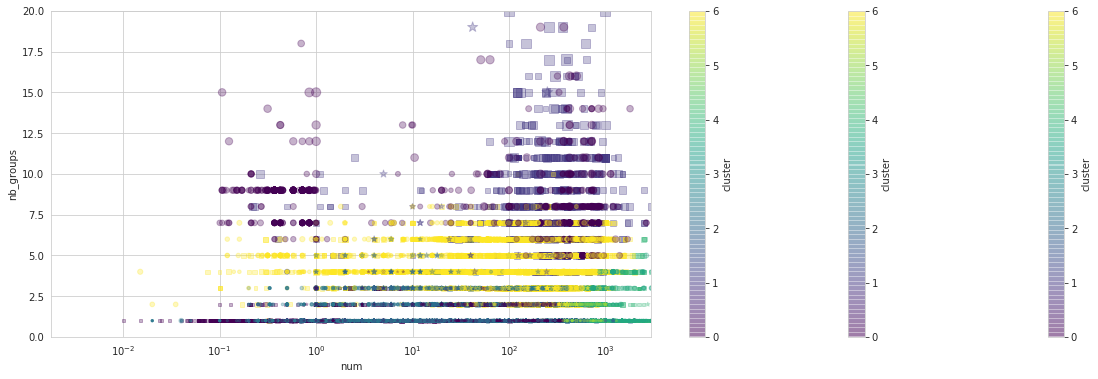

In [512]:
fig = plt.figure(figsize = (21, 6))
grid = plt.GridSpec(1, 1, wspace=0.2, hspace=0.1)
# grid = plt.GridSpec(1, 3, wspace=0.2, hspace=0.1)
np.warnings.filterwarnings('ignore')

mkr_dict = {'mass' : (1,'s'), 'volume' : (2,'o'), 'other' : (0,'*')}

ax1 = plt.subplot(grid[0, 0:1])
for mkr in mkr_dict:
  mask = df_quantity_f['q_unit_type'] == mkr_dict[mkr][0]
  log_num_max = 100*np.log(df_quantity_f[mask]['num'])
  df_quantity_f[mask].plot(ax = ax1, kind = 'scatter',
                           s = df_quantity_f[mask]['nb_char'],
                           y='nb_groups',x='num', c='cluster',
                           marker = mkr_dict[mkr][1], colormap='viridis',
                           xlim = (0,3000), ylim = (0,20), logx = True,
                           alpha=0.3, legend = False,) # figsize = (18,6))

# ax1 = plt.subplot(grid[0, 0:1])

# ax2 = plt.subplot(grid[0, 1:2])

# ax3 = plt.subplot(grid[0, 2:3])

# ax1.set_xlabel("number of groups (num-unit)")
# ax1.set_ylabel("total number of character")
# ax1.set_title("Features of 'quantity' data")

plt.show()

In [0]:
sound(10)

In [0]:
### Function giving description of data in a cluster
def analyses_cluster (df,n):
  df_cl = df[df['cluster']==n]
  print("o---- CLUSTER ", str(n), " ----o")
  print("nb rows", df_cl.shape[0])
  print("min and max num: ", df_cl['num'].min(), df_cl['num'].max())
  print("nb of empty unit: ", df_cl[(df_cl['unit']=='')].shape[0])
  print(df_cl['nb_groups'].value_counts())
 # print("----------- Data in the cluster with empty unit_max : --------")
 # return df_cl[(df_cl['unit_max']=='')]

In [514]:
# Checking the repartition of rows between clusters
for i in range(n_clust):
  print("cluster "+str(i)+" :",df_quantity_f[df_quantity_f['cluster']==i].shape)
# Then giving a summary of main characteristics
for i in range(n_clust):
  analyses_cluster(df_quantity_f,i)

cluster 0 : (145304, 13)
cluster 1 : (1732, 13)
cluster 2 : (5249, 13)
cluster 3 : (43027, 13)
cluster 4 : (6130, 13)
cluster 5 : (65498, 13)
cluster 6 : (15784, 13)
o---- CLUSTER  0  ----o
nb rows 145304
min and max num:  0.01 380.0
nb of empty unit:  0
1    139125
2      5362
3       804
4        13
Name: nb_groups, dtype: int64
o---- CLUSTER  1  ----o
nb rows 1732
min and max num:  0.1 3900.0
nb of empty unit:  0
7     358
9     346
8     332
6     178
10    134
5     107
11     96
12     54
13     24
14     21
4      20
15     16
16     11
17      6
19      6
18      4
23      4
21      3
31      2
20      2
22      2
26      2
24      1
25      1
27      1
32      1
Name: nb_groups, dtype: int64
o---- CLUSTER  2  ----o
nb rows 5249
min and max num:  0.095 1800.0
nb of empty unit:  0
1    4833
2     180
3     170
4      45
5      15
6       6
Name: nb_groups, dtype: int64
o---- CLUSTER  3  ----o
nb rows 43027
min and max num:  0.02 640.0
nb of empty unit:  0
1    40458
2     1828
3

In [515]:
# indexes of rows with empty 'unit'
idx_unit_na = df_quantity[df_quantity['unit'].isna()].index.to_list()
print("Found {} empty 'unit'.\n".format(len(idx_unit_na)))

# indexes of rows with 'num' 0, negative or values exceeding 6000
cond1 = df_quantity['num'].isna()
cond2 = df_quantity['num']>10000
cond3 = df_quantity['num']<=0
my_cond = (cond1|cond2|cond3)
idx_num_outl = df_quantity[my_cond].index.to_list()
print("Total {} outliers found in 'num'.".format(len(idx_num_outl)))
print("--> NaN: {0} - Outliers: {1} - Zero or negative: {2}".format(df_quantity[cond1].shape[0],
                                                    df_quantity[cond2].shape[0],
                                                    df_quantity[cond3].shape[0]))

Found 8420 empty 'unit'.

Total 9457 outliers found in 'num'.
--> NaN: 8420 - Outliers: 76 - Zero or negative: 961


In [0]:
# Dropping rows where unit or num is invalid in df_quantity
df_quantity.drop(index=idx_unit_na+idx_num_outl, inplace=True)
# Setting value of 'quantity' in dfcopy to NaN if unit or num is invalid 
dfcopy.loc[idx_unit_na+idx_num_outl, 'quantity'] = np.nan

In [518]:
# Merging df_quantity with dfcopy
print("dfcopy before: \n", dfcopy.shape, "\ndf_quantity: \n", df_quantity.shape)
dfcopy = dfcopy.merge(df_quantity[['num', 'unit','q_unit_type']],
                      how = 'left',  left_index=True, right_index=True)
dfcopy.rename(columns = {'num':'quantity_num',
                           'unit':'quantity_unit',
                           'q_unit_type':'quantity_type'},
                inplace=True)
# ---- NB : join on index works, whereas join on column 'quantity' doesn't.
cols = dfcopy.columns.to_list()
cols = cols[:9]+cols[-3:]+cols[9:-3]
dfcopy = dfcopy[cols]
print("---> dfcopy after: \n", dfcopy.shape)
dfcopy.head(3)

dfcopy before: 
 (954302, 104) 
df_quantity: 
 (282731, 12)
---> dfcopy after: 
 (954302, 107)


,code,code_val,url,creator,created_datetime,last_modified_datetime,product_name,generic_name,quantity,quantity_num,quantity_unit,quantity_type,packaging,brands,categories,categories_en,origins,manufacturing_places,labels,labels_en,emb_codes,first_packaging_code_geo,cities_tags,purchase_places,stores,countries,countries_en,ingredients_text,allergens,traces,traces_en,serving_size,serving_quantity,additives_n,additives_en,ingredients_from_palm_oil_n,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_tags,nutrition_grade_fr,nova_group,pnns_groups_1,pnns_groups_2,main_category,main_category_en,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,omega-6-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,-lactose_100g,starch_100g,polyols_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-dried_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,carbon-footprint_100g,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr,nutrition-score-uk
0,0000000000000010,False,http://world-en.openfoodfacts.org/product/0000...,openfoodfacts-contributors,2019-02-15T16:06:53Z,2019-02-15T16:06:53Z,NaN,NaN,NaN,nan,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:FR,France,NaN,NaN,NaN,NaN,NaN,nan,nan,NaN,nan,NaN,nan,NaN,NaN,nan,unknown,unknown,NaN,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,000000000000010,False,http://world-en.openfoodfacts.org/product/0000...,openfoodfacts-contributors,2019-02-15T16:07:11Z,2019-02-15T16:07:11Z,NaN,NaN,NaN,nan,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:FR,France,NaN,NaN,NaN,NaN,NaN,nan,nan,NaN,nan,NaN,nan,NaN,NaN,nan,unknown,unknown,NaN,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,0000000000017,True,http://world-en.openfoodfacts.org/product/0000...,kiliweb,2018-06-15T10:38:00Z,2019-06-25T11:55:18Z,Vitória crackers,NaN,NaN,nan,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,France,France,NaN,NaN,NaN,NaN,NaN,nan,nan,NaN,nan,NaN,nan,NaN,NaN,nan,unknown,unknown,NaN,NaN,1569,nan,7,3,nan,nan,nan,nan,nan,nan,70,15,nan,nan,nan,nan,8,1,1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [0]:
# Checking rows with one or more crucial missing values
.duplicated

# indexes of rows with invalid codes and all key_cols NaN 
inval_code_df = dfcopy[dfcopy['code_val']==False]
mask = inval_code_df.loc[:,key_cols].isna().all(axis=1)
ind = inval_code_df[mask].index.to_list() 
print("nb of rows with invalid code and all key-columns NaN:", len(ind))

In [0]:
sound(0)

In [0]:
# # Converting the database to prevent an error with pd profiling
# for c in df_inval_id:
#   if df_inval_id[c].dtypes != bool and df_inval_id[c].dtypes != np.float64 and \
#   df_inval_id[c].dtypes != np.uint64 and df_inval_id[c].dtypes != np.uint64 and \
#   df_inval_id[c].dtypes != np.uint8 and df_inval_id[c].dtypes != np.datetime64 and \
#     df_inval_id[c].dtypes != np.timedelta64 and df_inval_id[c].dtypes != np.dtype('<m8[ns]'):
#       df_inval_id[c] = df_inval_id[c].astype("str")
#       df_inval_id[c] = df_inval_id[c].astype("category")
#   elif df_inval_id[c].dtypes == bool:
#       df_inval_id[c] = df_inval_id[c].astype("int")
# # Generating a Data Profiling html report via pandas_profiling
# profile = pandas_profiling.ProfileReport(df_inval_id,check_correlation = False)
# profile.to_file("OFF_inexpl.html")
# profile

Data that have no key column filled have very few data anyway.
We drop all the 22178 rows.

In [0]:
print("nb of rows before:", dfcopy.shape[0])
dfcopy.drop(index=ind, inplace=True)
print("nb of rows after:", dfcopy.shape[0])

* Condition 2:

Let's now check for the second condition that is "at least one numerical columns filled" among a selection of numerical data OR nutritional score

In [0]:
def nb_rows_allna (df, selcol):
  mask = dfcopy[cruc_num_col].isna().all(axis=1)
  ind_drop = dfcopy[mask].index.to_list()
  return len(ind_drop), ind_drop
def print_nb(df, selcol):
  print("------ columns: ", selcol, "\nnb of rows all NaN : ", nb_rows_allna(df, selcol)[0])

In [0]:
#li_cat_comp li_cat_carb li_cat_fat li_cat_poly_fat 
cruc_num_col = ['energy_100g']
print_nb(dfcopy, cruc_num_col)
cruc_num_col += li_cat_comp
print_nb(dfcopy, cruc_num_col)
cruc_num_col += ['salt_100g']
print_nb(dfcopy, cruc_num_col)
cruc_num_col += li_cat_nutri
print_nb(dfcopy, cruc_num_col)
cruc_num_col += li_cat_vit_oligo
print_nb(dfcopy, cruc_num_col)

In [0]:
dfcopy.loc[nb_rows_allna(dfcopy, cruc_num_col)[1]].head(4)

We drop the 166 921 rows that do not have either one of the following numerical '**XXX_100g**' columns OR one of the nutritional data columns **li_cat_nutri** filled.

### Dealing with duplicates
Step by step :
- _absolute duplicates_ : keep the first
- _duplicates among key columns ('code')_ :
keep the row with less missing values, and if there're the same, keep the row with most distinct values

(One Function including all the steps "dealing_duplicates")

In [0]:
# detect duplicates
mask = dfcopy.duplicated(subset=['quantity', 'product_name', 'brands'], keep=False) # mark all duplicates as True
#dfcopy[mask]
mask

In [0]:
def dealing_duplicates (df, key_cols):
  # Delete duplicated rows (all columns)
  dup_all_ser = df_clean.duplicated(subset=None, keep='first')
  df_clean.drop(index = df_clean[dup_all_ser.values == True].index, inplace=True)
  # Dealing with duplicated rows (among key columns)
  dup_key_df = df_clean[df_clean.duplicated(subset=key_cols,
                                            keep=False).values]
  # ranging indexes by decreasing amount of 'nan's then by distinct values
  li_ind = pd.DataFrame({'n_rens' : df.isna().T.sum().values,
                'n_dist' : len(df.iloc[1].T.unique())},
                              index = ech.index.values)\
          .sort_values(by=["n_rens", "n_dist"], ascending = True).index
  df_comb = df.loc[li_ind[0]:li_ind[0]]
  # combine the rows in appropriate order
  for ind in li_ind:
      df_comb = df_comb.reset_index().combine_first(df.loc[ind:ind]\
                       .reset_index()).set_index('index').rename_axis(None)
  # replaces the unique row and drop useless rows
  df_clean.update(df_comb, overwrite=True)
  df_clean.drop(li_ind[1:], inplace = True)
  return df_clean

In [0]:

# Number of duplicates considering all columns or selection of crucial columns
dup_all_ser.sum(), dup_code_ser.sum(), dup_name_ser.sum(),\
dup_code_name_ser.sum(), dup_name_quant_ser.sum()




# Eliminating rows with crucial data missing
# (no null row to eliminate)
df_clean = df_clean.drop(columns = col_miss_val)
df_clean.shape
# Eliminating columns with more than 2.5% missing values
#(no null row to eliminate)
df_clean = df_clean.drop(columns = col_miss_val)
df_clean.shape

In [0]:
np.nansum(dup_key_df.groupby(by=['code','product_name','quantity','brands']).count()["url"].values)
New column 'quantity_norm' with normalized quantities (put all in g, numeric)
df_clean["quantity"]
df.replace(to_replace=r'g', value='', regex=True)
dup_key_df.groupby(by=['code','product_name','quantity','brands']).count().shape#
dup_code_ser = df.duplicated(subset=['code'], keep='first')
dup_name_ser = df.duplicated(subset=['product_name'], keep='first')
dup_code_name_ser = df.duplicated(subset=['code','product_name'], keep='first')
dup_name_quant_ser = df.duplicated(subset=['quantity','product_name'], keep='first')